In [1]:
%load_ext autoreload

In [13]:
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import handytools.navigator as nav
import handytools.visualizer as vis
import spectools.models.models as mdl
from copy import deepcopy
from spectools.stimulus.wyeth import get_stimulus
from spectools.responses import get_response_wrapper, get_drr_wrapper
from spectools.metrics.metrics import responsive
from spectools.models.models import AN_layer, VGG16b_layer, ResNet18_layer
from spectools.stimulus.dataloader import get_50000_images

In [15]:
# params
hkeys = list(AN_layer.keys())[:-3]
mtype = "AN"
seed = 42
np.random.seed(seed)

In [4]:
TI = {}
for hkey in hkeys:
    Rc = nav.npload(nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_TK_norm=standard.npy") # originally TKRc
    TI[hkey] = []

    for Runit in Rc:
        Rshape = Runit[:225]
        Rtexture = Runit[225:]
        TI[hkey].append(np.std(Rtexture)/np.std(Rshape))

In [11]:
# define input
B = 200
random_idxs = np.random.choice(range(50000), B)
dataset = get_50000_images(random_idxs)
X = [dataset[idx].unsqueeze(0) for idx in range(B)]
X = torch.vstack(X)

# define models
if mtype == "AN": mfunc = mdl.get_alexnet; ldic = mdl.AN_layer
elif mtype == "VGG16": mfunc = mdl.get_vgg16; ldic = mdl.VGG16_layer
elif mtype == "VGG16b": mfunc = mdl.get_vgg16b; ldic = mdl.VGG16b_layer
hkeys = list(ldic.keys())[:-3]
model = mfunc(hidden_keys=hkeys)

In [17]:
# permutation
permts = [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]

Rcs_all = {}
for hkey in hkeys: Rcs_all[hkey] = [] 

for permt in permts:
    X_copy = deepcopy(X)
    X_permt = X_copy[:, permt]

    permt_str = ":".join([str(i) for i in permt])
    fname = lambda hkey: f"hkey={hkey}_rotatecolor_permt={permt_str}_seed={seed}.npy"
    Rcs = get_response_wrapper(hkeys, X_permt, fname, mtype=mtype, save=True) # key=hkey, value.shape=(#units, B)

    for hkey in hkeys:
        Rcs_all[hkey].append([Rcs[hkey]])

colordic = {}
for hkey in hkeys:
    Rcs = Rcs_all[hkey] = np.vstack(Rcs_all[hkey]) # value.shape = (6, #units, B)
    base = Rcs[0].std(axis=1) # shape = (#units,)
    color_indices = Rcs.std(axis=0).mean(axis=1)/base # shape = (#units,)
    colordic[hkey] = color_indices

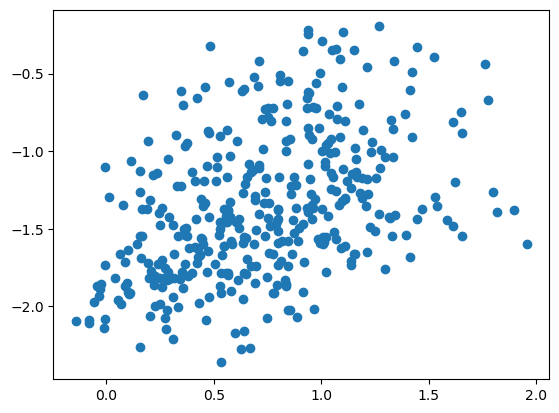

In [22]:
hkey = 6
plt.scatter(np.log(TI[hkey]), np.log(colordic[hkey]))